This notebook is for testing reconstruction on iq data

## import section

In [1]:
%matplotlib inline 
import scipy.io as sio
import scipy.signal as scs
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib as npml
import time
import reconstruct_image as ri

## loading simulation data

In [2]:
# path to data file

# mode = 'sta'
# mode = 'pwi'
mode = 'lin'

if mode == 'sta':
    file = '/media/linuser/data01/praca/us4us/' \
         'us4us_testData/dataSets02/rfSta_field.mat'
    print('STA mode')
elif mode == 'pwi':
    file = '/media/linuser/data01/praca/us4us/' \
           'us4us_testData/dataSets02/rfPwi_field.mat'
    print('PWI mode')
elif mode == 'lin':
    file = '/media/linuser/data01/praca/us4us/' \
           'us4us_testData/dataSets02/rfLin_field.mat'
    print('conventional mode')
else:
    raise ValueError('unknown reconstruction mode!')



# ippt
# file = '/home/linuser/us4us/usgData/rfLin_field.mat'


       

# load data
[rf, c, fs, fc, pitch,
tx_focus, tx_angle, tx_aperture,
n_elements, pulse_periods] = ri.load_simulated_data(file, 1)

conventional mode
input data keys:  dict_keys(['__header__', '__version__', '__globals__', 'fn', 'fs', 'nElem', 'nPer', 'pitch', 'rfLin', 'sos', 'txAp', 'txFoc', 'txAng'])
 
 
speed of sound:  1540.0
sampling frequency:  65000000.0
pulse (carrier) frequency:  5000000.0
pitch:  0.00021
aperture length:  192
focal length:  0.02
subaperture length:  48
transmission angles:  [[0.]]
number of pulse periods:  2


## reconstruction from raw rf data (universal approach)

In [3]:
# define grid for reconstruction (imaged area)
x_grid = np.linspace(-3.3*1e-3, 3.3*1e-3, 64)
z_grid = np.linspace(9*1e-3, 12.*1e-3, 64)

# reconstruct data
start_time = time.time()
rf_image = ri.reconstruct_rf_img(rf, x_grid, z_grid,
                           pitch, fs, fc, c,
                           tx_aperture, tx_focus, tx_angle,
                           pulse_periods, tx_mode=mode
                           )


end_time = time.time() - start_time
end_time = round(end_time*10)/10
print("--- %s seconds ---" % end_time)

rf (real) data on input
 100.0 %3.4 %96.4 %
--- 3.3 seconds ---


## creating B-mode image

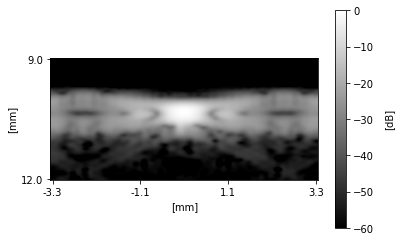

In [4]:
ri.make_bmode_image(rf_image, x_grid, z_grid)

## converting from RF to IQ

In [ ]:
dec = 4
start_time = time.time()

# This line (below) run rf2iq() on whole 'rf' array at once - it will crash when lack of memory
# iq = ri.rf2iq(rf, fc, fs, dec)


# The following code cut the 'rf' array and run rf2iq() on smaller pieces  
rfshape = rf.shape
n_row = rfshape[0]
drow = 1024
row_0 = 0
row_1 = row_0 + drow

print('converting starts...')
krf = rf[row_0:row_1,:,:]
iq = ri.rf2iq(krf, fc, fs, dec)


while 1:
    print('converted ', row_1*100//n_row, '%')
    row_0 = row_1
    row_1 = row_0 + drow
    
    if row_0 >= n_row:
        break
        
    if row_1 > n_row:
        row_1 = n_row
    
    krf = rf[row_0:row_1,:,:]
    kiq = ri.rf2iq(krf, fc, fs, dec)
    iq = np.concatenate((iq,kiq))



end_time = time.time() - start_time
end_time = round(end_time*10)/10
print("--- %s seconds ---" % end_time)

# print(rf.shape)
# print(iq.shape)


converting starts...
converted  22 %
converted  44 %
converted  67 %


## reconstruction from iq

In [ ]:
# define grid for reconstruction (imaged area)
x_grid = np.linspace(-3.3*1e-3, 3.3*1e-3, 64)
z_grid = np.linspace(9*1e-3, 12.*1e-3, 64)

# reconstruct data # uwaga - powinno byc fs/dec, ale wtedy jest zle <- tutaj trzeba sprawdzic
start_time = time.time()
iq_image = ri.reconstruct_rf_img(iq, x_grid, z_grid,
                                 pitch, fs/dec, fc, c,
                                 tx_aperture, tx_focus, tx_angle,
                                 pulse_periods, tx_mode=mode
                                 )

end_time = time.time() - start_time
end_time = round(end_time*10)/10
print("--- %s seconds ---" % end_time)

# draw b-mode image
ri.make_bmode_image(iq_image,x_grid,z_grid)

## testowanie iq (znowu)

In [ ]:
line = rf[:,1,1]
env = ri.calculate_envelope(line)

plt.figure(1)
plt.plot(env)


print('line shape:', line.shape)
iqline = ri.rf2iq(line, fc, fs, 1)
print('iqline shape:',iqline.shape)
iqenv = np.abs(iqline)

print(iqenv.shape)

plt.figure(2)
plt.plot(iqenv)



s = np.fft.fft(line)
siglen = len(line)
f = np.fft.fftfreq(siglen,1/fs)
f = np.squeeze(f)
plt.figure(3)
plt.plot(f, abs(s)), plt.show()




s = np.fft.fft(iqline)
siglen = len(iqline)
f = np.fft.fftfreq(siglen,1/fs)
f = np.squeeze(f)
plt.figure(4)
plt.plot(f, abs(s)), plt.show()

In [ ]:
plt.figure(1)
plt.imshow(ri.calculate_envelope(rf[1000:1500,:,1]),
               interpolation='bicubic',
#                aspect=data_aspect,
               cmap='gray'
#                vmin=-60, vmax=0
               )


plt.figure(2)
plt.imshow(np.abs(iq[1000:1500,:,1]),
               interpolation='bicubic',
#                aspect=data_aspect,
               cmap='gray'
#                vmin=-60, vmax=0
               )

In [ ]:

plt.figure(1)
plt.plot(ri.calculate_envelope(rf[:,32,32]))

plt.figure(1)
plt.plot(np.abs(iq[:,32,32]))
